Autoencoder

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import os
import glob

2024-06-01 18:46:02.327286: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-01 18:46:02.550909: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-01 18:46:02.550937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-01 18:46:02.589141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-01 18:46:02.673793: I tensorflow/core/platform/cpu_feature_guar

Carga de datos

In [2]:
def leer_jpg_de_subcarpetas(carpeta_principal):
    # Obtener todas las rutas de archivos .jpg en todas las subcarpetas
    rutas_jpg = glob.glob(os.path.join(carpeta_principal, '**', '*.jpg'), recursive=True)
    
    return rutas_jpg

def load_files(files_list):
    data=[]
    for file_path in files_list:
        img=cv2.imread(file_path)
        data.append(img)
    return data

In [3]:
path='/mnt/d/Repositorios/Deep_Learning/Temas Selectos/P2/AUTOENCODER/Image_autoencoder/Dataset'
jpg_path=leer_jpg_de_subcarpetas(path)
print(len(jpg_path))

9997


In [4]:
data=[]
print(len(jpg_path))
batch_size=len(jpg_path)//13
step=0
for i in range(13):
    data+=load_files(jpg_path[step:batch_size+step])
    step+=batch_size

9997


Exploración de los datos


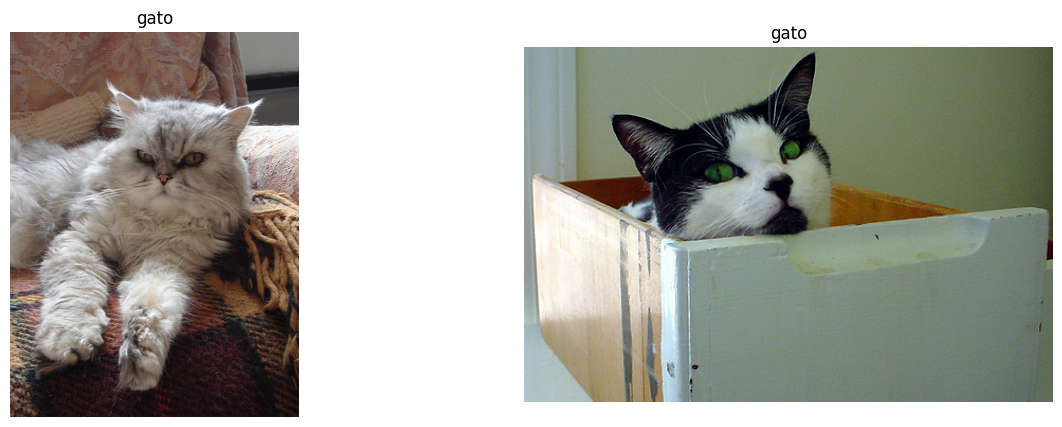

In [5]:
def show_images(image_paths, titles):
    num_images = len(image_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Ajustar el tamaño de la figura según el número de imágenes
    for i in range(num_images):
        # Cargar la imagen y convertirla a RGB
        image = cv2.cvtColor(cv2.imread(image_paths[i]), cv2.COLOR_BGR2RGB)
        # Mostrar la imagen en la subtrama correspondiente
        axes[i].imshow(image)
        axes[i].axis('off')  # Desactivar los ejes
        axes[i].set_title(titles[i])  # Establecer el título de la subtrama
    plt.show()
    
def show_loaded_images(images, titles):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Ajustar el tamaño de la figura según el número de imágenes
    
    for i in range(num_images):
        # Convertir la imagen de BGR a RGB
        image_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        
        # Mostrar la imagen en la subtrama correspondiente
        axes[i].imshow(image_rgb)
        axes[i].axis('off')  # Desactivar los ejes
        axes[i].set_title(titles[i])  # Establecer el título de la subtrama
    
    plt.show()
image_paths = [jpg_path[0], jpg_path[8000]]
titles = ['gato', 'gato']
show_images(image_paths, titles)

Normalizado de los datos

In [6]:
def shape_fix(img):
    if img.shape[1]<img.shape[0]:
        image=img[0:img.shape[1],0:img.shape[1]]
    elif img.shape[1]>img.shape[0]:
        image=img[0:img.shape[0],0:img.shape[0]]
    else:
        image=img
    return cv2.resize(image,(128,128))

In [7]:
fixed_images=[shape_fix(image) for image in data]

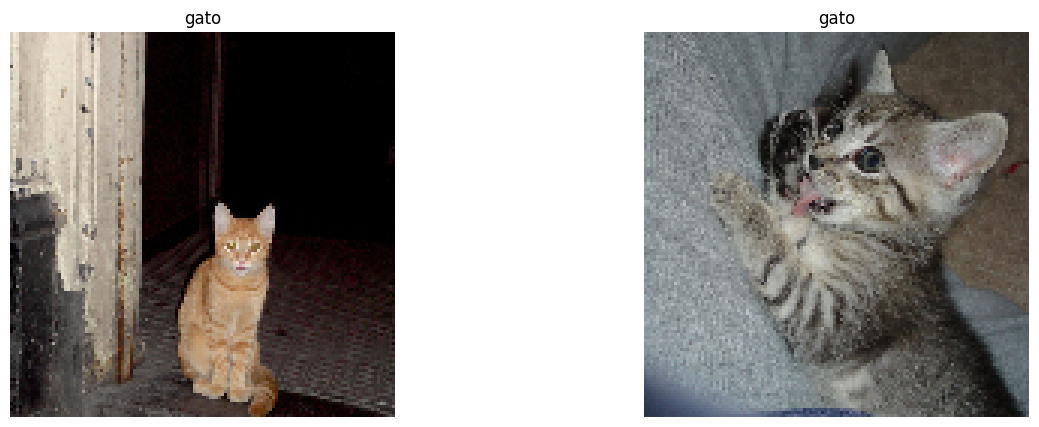

In [8]:
show_loaded_images((fixed_images[400],fixed_images[250]),['gato','gato'])

In [9]:
for image in fixed_images:
    image=image/255
    image=tf.convert_to_tensor(image,dtype=tf.float32)

2024-06-01 18:47:48.789869: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 18:47:48.975014: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 18:47:48.975050: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 18:47:48.977625: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-01 18:47:48.977659: I external/local_xla/xla/stream_executor

Modelo

In [10]:
#Encoder
input_layer=tf.keras.layers.Input((128,128,3))
encoder=tf.keras.Sequential([
    input_layer,
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Conv2D(filters=48,kernel_size=(1,1),activation='relu',padding='same')
    
])
#encoder.build()
encoder.summary()
Latent_size=(16,16,48)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 256)       0

In [11]:
decoder=tf.keras.Sequential([
    tf.keras.layers.Input(shape=Latent_size),
    tf.keras.layers.Conv2D(256,(1,1),activation='relu',padding='same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu',padding='same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.UpSampling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.Conv2D(3,(3,3),activation='sigmoid',padding='same')
    
])
#decoder.build()
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 16, 16, 256)       12544     
                                                                 
 up_sampling2d (UpSampling2  (None, 32, 32, 256)       0         
 D)                                                              
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 64, 64, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       295040    
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 128, 128, 128)    

In [12]:
encoded_input=encoder.input
encoded_output=encoder.output

decoded_output=decoder(encoded_output)

Autoencoder=tf.keras.models.Model(inputs=encoded_input,outputs=decoded_output)
Autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      


                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 48)        12336     
          

In [13]:
Autoencoder.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy','loss'])

Entrenamiento

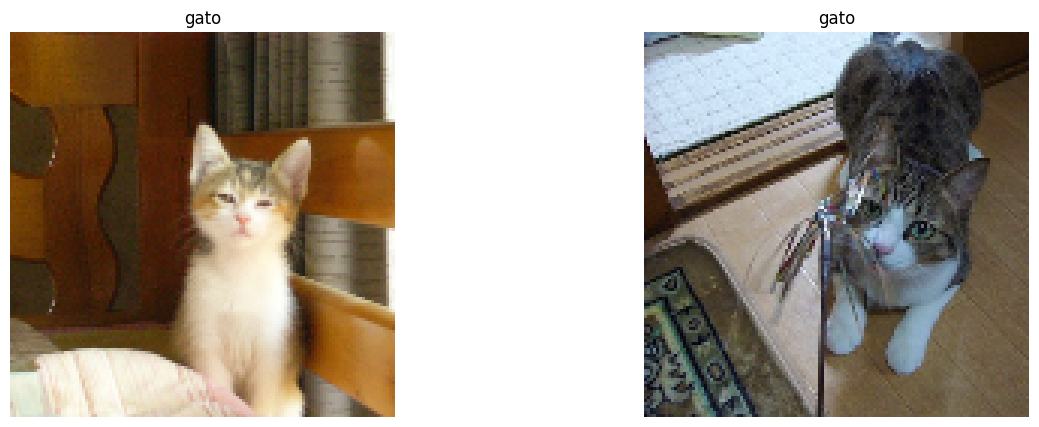

In [14]:
np.random.shuffle(fixed_images)
#print(len(data))
show_loaded_images((fixed_images[0],fixed_images[9000]),['gato','gato'])


In [15]:
X_train,X_test,_,_=train_test_split(fixed_images,fixed_images,test_size=.2,random_state=42)
X_test,X_valid,_,_=train_test_split(X_test,X_test,test_size=.2,random_state=42)

7997
1600
400


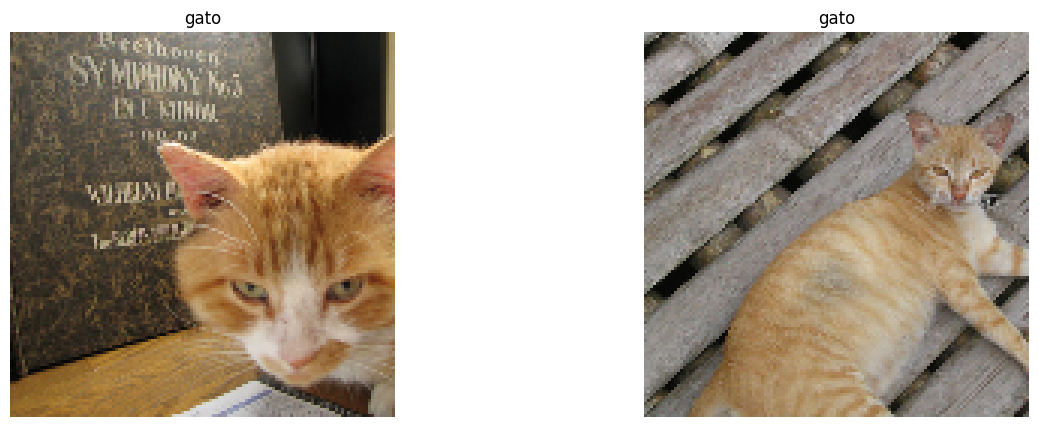

In [16]:
print(len(X_train))
print(len(X_test))
print(len(X_valid))
show_loaded_images((X_train[0],X_test[1500]),['gato','gato'])

In [17]:
X_train=np.array(X_train)
X_test=np.array(X_test)
X_valid=np.array(X_valid)

In [18]:
print(X_train[600].shape)

(128, 128, 3)


In [19]:
batch_size=200
epochs=15
history=Autoencoder.fit(X_train,X_train,epochs=epochs,batch_size=batch_size,validation_data=(X_valid,X_valid))

Epoch 1/15


TypeError: in user code:

    File "/home/alvaromontero/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/alvaromontero/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/alvaromontero/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/alvaromontero/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/alvaromontero/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/alvaromontero/.local/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/alvaromontero/.local/lib/python3.10/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "/home/alvaromontero/.local/lib/python3.10/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/alvaromontero/.local/lib/python3.10/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: 'str' object is not callable
